# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

### Recomendación: usar matplotlib, wfdb, scipy.io

In [2]:
# Define una función reutilizable para cargar y plotear un segmento ECG
def plot_ecg_segment(data_dir):
  
    import os
    import scipy.io as sio
    import matplotlib.pyplot as plt
    import numpy as np

     # Buscamos archivos .mat y tomamos sólo el primero
    mat_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.mat')])
    if not mat_files:
        raise FileNotFoundError(f"No se encontraron .mat en {data_dir}")
    file0 = mat_files[0]

    # Cargamos la señal
    mat = sio.loadmat(os.path.join(data_dir, file0))
    if 'val' in mat:
        signal = mat['val']
    elif 'ECG' in mat:
        signal = mat['ECG']
    else:
        raise KeyError("La señal no está bajo 'val' ni 'ECG'")
    signal = signal.flatten()

    # Parámetros internos fijos
    fs = 300            # Hz
    duration = 10       # segundos

    # Tomamos los primeros 10 s
    n_samples = min(len(signal), fs*duration)
    time = np.arange(n_samples) / fs
    segment = signal[:n_samples]


    plt.figure(figsize=(12,4))
    plt.plot(time, segment, lw=0.8)
    plt.title(f"ECG – {file0} ({duration} s)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.xlim(0, duration)
    plt.show()

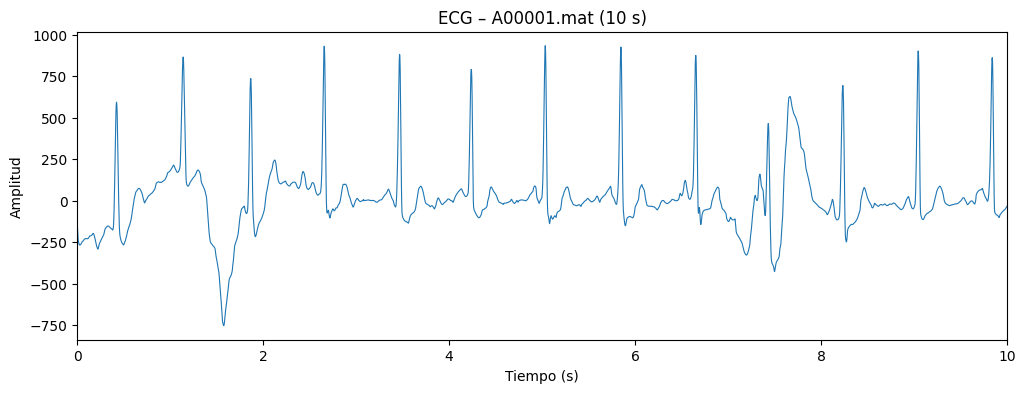

In [3]:
from pathlib import Path

# ./training2017
data_dir = Path("../data/training2017")
plot_ecg_segment(data_dir)

In [ ]:
#%pip install wfdb scipy pandas matplotlib
import os
from wfdb import rdrecord
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

# Directorio de registros y etiquetas
data_dir = Path("../data/training2017")
ref = pd.read_csv(os.path.join(data_dir, "REFERENCE.csv"),
                  header=None, names=['registro','label'])
label_map = {'N':'Normal', 'A':'AFib'}
ref['label'] = ref['label'].map(label_map).fillna('Other')
ref_dict = ref.set_index('registro')['label'].to_dict()

# Listado y muestreo de archivos
records = []
fs_target = 300
max_duration = 10  # segundos
for fname in sorted(f for f in os.listdir(data_dir) if f.endswith('.mat'))[:30]:
    rec_name = os.path.splitext(fname)[0]
    rec = rdrecord(os.path.join(data_dir, rec_name))
    sig = rec.p_signal[:,0]      # primera derivación
    fs = int(rec.fs)
    n_samples = min(len(sig), fs*max_duration)
    segment = sig[:n_samples]
    duration_seq = n_samples / fs

    # Estadísticas de amplitud
    media_mv = segment.mean()
    mstd_mV = segment.std()
    skewness = skew(segment)
    kurt_val = kurtosis(segment)

    # RR intervals
    peaks, _ = find_peaks(segment, distance=0.6*fs)
    rr = np.diff(peaks) / fs
    rr_mean_s = rr.mean() if rr.size>0 else np.nan
    rr_std_s  = rr.std()  if rr.size>0 else np.nan

    # Clase
    label = ref_dict.get(rec_name, 'Unknown')

    records.append({
        'registro':     rec_name,
        'label':        label,
        'fs':           fs,
        'duracion_seq': duration_seq,
        'media_mv':     media_mv,
        'mstd_mV':      mstd_mV,
        'skewness':     skewness,
        'kurtosis':     kurt_val,
        'rr_mean_s':    rr_mean_s,
        'rr_std_s':     rr_std_s
    })

# Guardar CSV
df = pd.DataFrame(records)
out_csv = Path("../data/ecg_features.csv")
df.to_csv(out_csv, index=False)
print("Total registros:", df.shape[0])
print("Recuento por clase:")
print(df['label'].value_counts())


Total registros: 30
Recuento por clase:
label
Normal    15
AFib      15
Name: count, dtype: int64


In [ ]:
## 2. Inspección básica del dataset
# cargar el CSV generado
csv_path = Path("../data/ecg_features.csv")
df = pd.read_csv(csv_path)

# vista previa
display(df.head())

# estadísticos básicos
display(df.describe())

# tipos de datos
print(df.dtypes)

,registro,label,fs,duracion_seq,media_mv,mstd_mV,skewness,kurtosis,rr_mean_s,rr_std_s
0,A00001,Normal,300,10.0,0.010062,0.201461,1.223713,5.415730,0.784722,0.030746
1,A00002,Normal,300,10.0,0.022602,0.153163,3.262134,21.159241,0.933667,0.155030
2,A00003,Normal,300,10.0,0.004400,0.115124,-2.051948,7.019234,0.752821,0.026853
3,A00004,AFib,300,10.0,0.052524,0.233103,2.971334,9.351437,0.995667,0.190701
4,A00005,AFib,300,10.0,0.008348,0.233297,1.429755,5.001859,0.809722,0.159777


,fs,duracion_seq,media_mv,mstd_mV,skewness,kurtosis,rr_mean_s,rr_std_s
count,30.0,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,300.0,10.0,0.006283,0.243919,0.421468,8.508109,0.862329,0.135397
std,0.0,0.0,0.021661,0.163718,1.946161,6.880700,0.089725,0.065897
min,300.0,10.0,-0.027491,0.097949,-2.791399,1.861939,0.721538,0.013009
25%,300.0,10.0,-0.006520,0.155155,-1.209532,3.513456,0.786806,0.082094
50%,300.0,10.0,0.002859,0.205483,0.427926,6.884128,0.858636,0.137796
75%,300.0,10.0,0.012405,0.258885,1.727610,10.778752,0.931583,0.181536
max,300.0,10.0,0.060549,0.899598,4.540715,35.240069,1.073333,0.239246


registro         object
label            object
fs                int64
duracion_seq    float64
media_mv        float64
mstd_mV         float64
skewness        float64
kurtosis        float64
rr_mean_s       float64
rr_std_s        float64
dtype: object


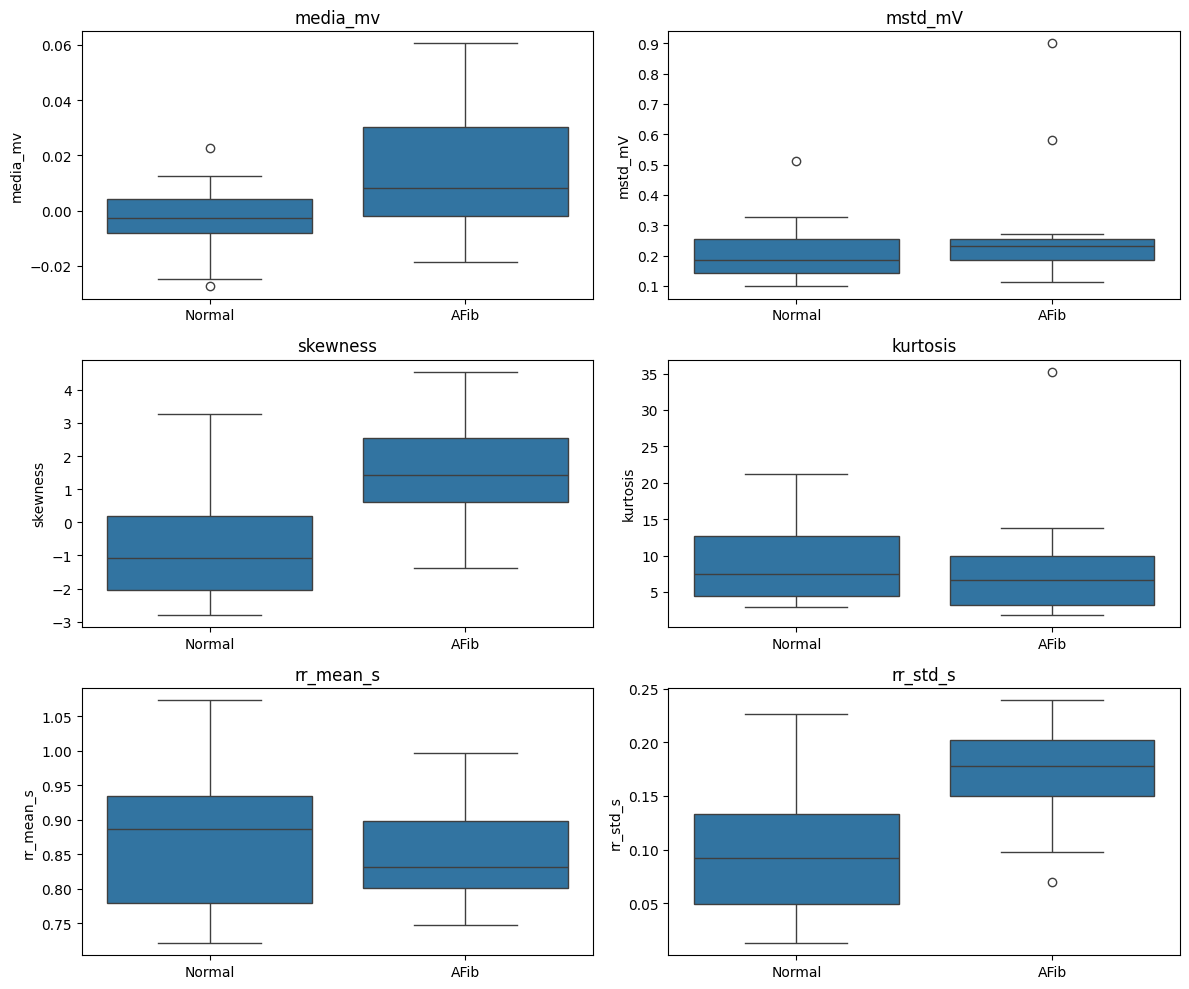

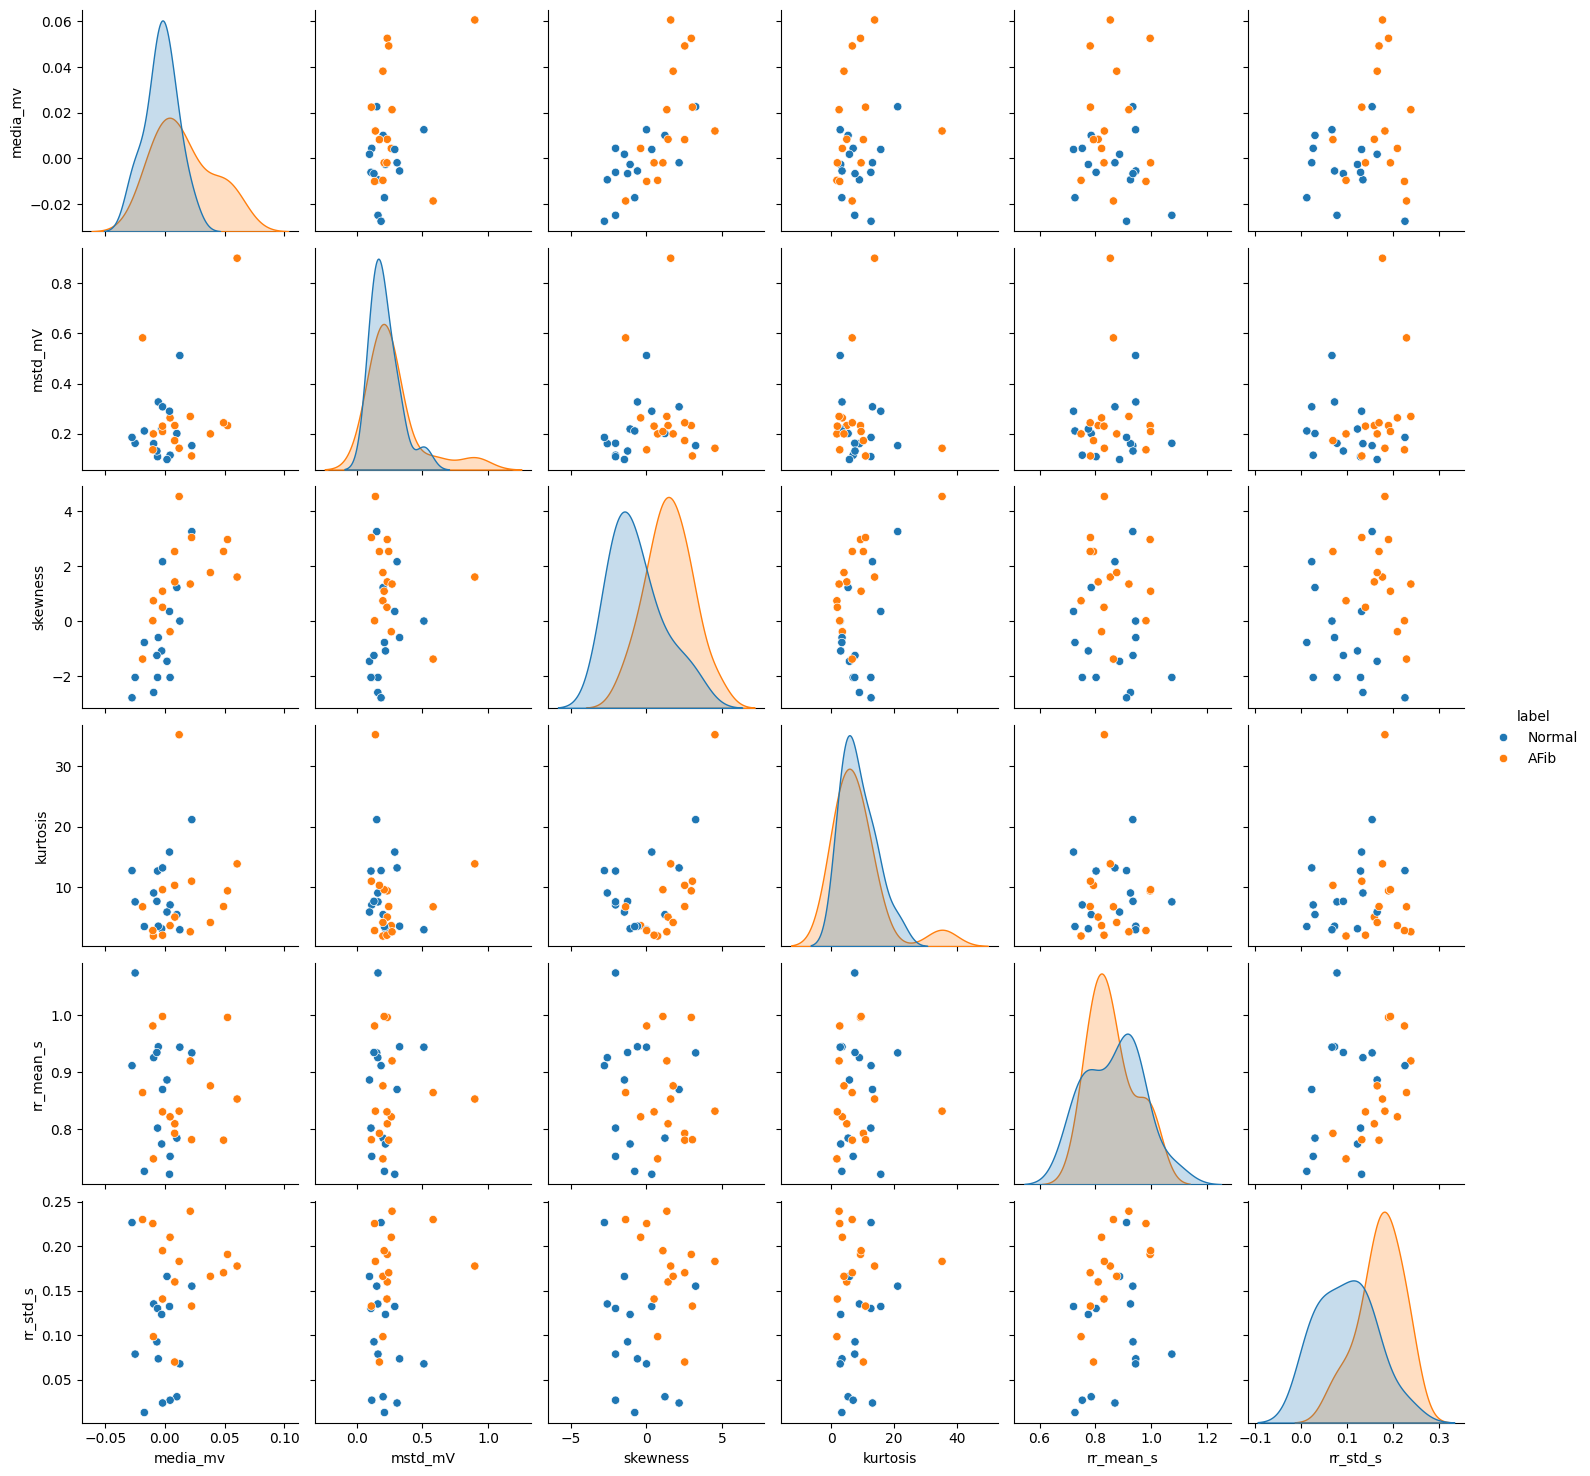

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Visualización de distribuciones por clase
features = ['media_mv','mstd_mV','skewness','kurtosis','rr_mean_s','rr_std_s']

# Boxplots
fig, axes = plt.subplots(3, 2, figsize=(12,10))
for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(x='label', y=feat, data=df, ax=ax)
    ax.set_title(feat)
    ax.set_xlabel('')
plt.tight_layout()
plt.show()

# Pairplot
sns.pairplot(df, vars=features, hue='label', diag_kind='kde', height=2.5)
plt.show()

**Conlusiones**

1. ¿Qué variables parecen diferenciar más entre clases?

- skewness: los valores de asimetría para AFib están claramente desplazados hacia la derecha (positivos), mientras que los normales tienden a ser negativos.
- rr_std_s: la desviación de los intervalos RR es notablemente mayor en AFib.

- mstd_mV: la dispersión de la señal (desviación estándar) es ligeramente superior en AFib.

- rr_mean_s: la media de los intervalos RR tiende a ser algo menor en AFib, aunque con cierto solapamiento.

2. ¿Qué aspectos del dataset llaman la atención?  
- Hay bastante solapamiento en algunas métricas (por ejemplo, rr_mean_s y media_mv), lo que dificulta una separación perfecta.
- Existen outliers marcados, sobre todo en kurtosis y en algunos casos de mstd_mV.
- El tamaño (30 registros) es reducido; convendría ampliar el conjunto para validar estas tendencias con mayor robustez.
